# RecLM

A recurrent language model is trained, with the following features:

1. WeightDrop on the RNN layers
2. Variational dropout on the embedding layer
3. Weight tie in between the embedding layer, and final linear layer which outputs a one-hot encoding
4. Variable back propagation through time
5. Independent embedding sizes and hidden sizes
6. Activation Regularization and Temporal Activation Regularization
7. Variational dropout on all other layers

This is effectively the language model described in [this paper](https://arxiv.org/abs/1708.02182)

In [21]:
# % load_ext autoreload
# % autoreload 2
% matplotlib inline

In [22]:
from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch import nn

In [3]:
from lm.data import LMDataLoader
from lm.models import RecLM, ARTAR, accuracy
from lm.schedulers import OneCycle

In [4]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

Loading the data, making dataloaders

In [5]:
dict_path = Path('word2int.pickle')
with dict_path.open('rb') as file:
    d = pickle.load(file)

In [6]:
xtrain = np.load('wikitext_train_int_tokens.npy')
xval = np.load('wikitext_valtest_int_tokens.npy')

In [7]:
xtrain_tensor = torch.from_numpy(xtrain).long()
xval_tensor = torch.from_numpy(xval).long()

if device.type == 'cuda':
    xtrain_tensor = xtrain_tensor.cuda()
    xval_tensor = xval_tensor.cuda()

In [8]:
train_dataloader = LMDataLoader(xtrain_tensor, 70, 64)
val_dataloader = LMDataLoader(xval_tensor, 70, 64)

In [9]:
vocab_size = len(d)
padding_idx = d['_pad_']

In [10]:
model = RecLM(vocab_size=vocab_size, padding_idx=padding_idx).cuda()

In [11]:
model

RecLM(
  (embedding): VDEmbedding(
    (embedding): Embedding(30002, 400, padding_idx=0)
  )
  (wdrnn_0): WDLSTM(
    (lstm): LSTM(400, 1150)
  )
  (wdrnn_1): WDLSTM(
    (lstm): LSTM(1150, 1150)
  )
  (wdrnn_2): WDLSTM(
    (lstm): LSTM(1150, 400)
  )
  (decoder): Linear(in_features=400, out_features=30002, bias=True)
  (emb_drop): VariationalDropout()
  (final_rnn_drop): VariationalDropout()
)

Finally, define our losses

In [12]:
crit = nn.CrossEntropyLoss()
regularizing_loss = ARTAR()

Now, a first round of training, to make sure everything actually works.

In [13]:
optimizer = torch.optim.Adam(model.parameters())

I kept getting out of memory errors when finding the min and max learning rates (presumably from removing `flatten_parameters`), but I was able to figure out a `max_lr` of `0.03`

In [15]:
scheduler = OneCycle(optimizer, len(train_dataloader), upswing=2, downswing=18, min_lr=1e-5,
                     max_lr=0.03)

In [16]:
num_epochs = scheduler.num_epochs()

In [17]:
hidden = [None, None, None]

In [18]:
overall_train = defaultdict(list)
overall_val = defaultdict(list)

for epoch in range(num_epochs):
    # set the model to train
    model.train()
    # keep track of training scores, so they can be displayed later
    train_scores = defaultdict(list)
    
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()
        
        x, y = batch
        pred, hidden, finals = model(x, hidden)
        
        loss = crit(pred, y)
        acc = accuracy(pred, y)
        reg = regularizing_loss(finals)
        
        train_scores['loss'].append(loss.item())
        train_scores['reg'].append(reg.item())
        train_scores['accuracy'].append(acc)
        
        total_loss = loss + reg
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_output_strings = []
    for key, val in train_scores.items():
        mean_value = np.array(val).mean()
        train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
        overall_train[key].append(mean_value)
        
    if val_dataloader:
        model.eval()
        val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in enumerate(val_dataloader):
                x, y = batch
                pred = model(x, hidden)
                val_loss = crit(pred, y)
                acc = accuracy(pred, y)
                
                val_scores['loss'].append(val_loss)
                val_scores['accuracy'].append(acc)
                
        val_output_strings = []
        for key, val in val_scores.items():
            mean_value = np.array(val).mean()
            val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
            overall_val[key].append(mean_value)
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}'.format(*val_output_strings))

  0%|          | 0/514 [00:00<?, ?it/s]/home/ubuntu/workdir/language_model/lm/models/awd_lstm.py:63: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, (hn, cn) = self.lstm(x, h0)
  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 9.39743, reg: 3.53294, accuracy: 0.04096
VALIDATION: loss: 7.917140007019043, accuracy: 0.04793


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.30337, reg: 0.00034, accuracy: 0.05906
VALIDATION: loss: 6.9092302322387695, accuracy: 0.06042


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.11521, reg: 3e-05, accuracy: 0.0624
VALIDATION: loss: 6.797530174255371, accuracy: 0.06979


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.12331, reg: 0.00033, accuracy: 0.06101
VALIDATION: loss: 6.944940090179443, accuracy: 0.06324


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.11028, reg: 0.00325, accuracy: 0.06379
VALIDATION: loss: 6.906489849090576, accuracy: 0.0628


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.13713, reg: 2e-05, accuracy: 0.06134
VALIDATION: loss: 6.9008002281188965, accuracy: 0.06611


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.07108, reg: 2e-05, accuracy: 0.06428
VALIDATION: loss: 6.918019771575928, accuracy: 0.06353


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.09352, reg: 0.00023, accuracy: 0.06204
VALIDATION: loss: 6.860879898071289, accuracy: 0.06936


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.06866, reg: 3e-05, accuracy: 0.06075
VALIDATION: loss: 6.910319805145264, accuracy: 0.06383


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.07027, reg: 7e-05, accuracy: 0.0631
VALIDATION: loss: 6.895810127258301, accuracy: 0.06863


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.05918, reg: 0.00021, accuracy: 0.06082
VALIDATION: loss: 6.899219989776611, accuracy: 0.06515


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.03911, reg: 3e-05, accuracy: 0.0639
VALIDATION: loss: 6.859930038452148, accuracy: 0.0612


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.08462, reg: 0.0001, accuracy: 0.0625
VALIDATION: loss: 6.823339939117432, accuracy: 0.06412


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.08604, reg: 0.00182, accuracy: 0.06075
VALIDATION: loss: 6.850170135498047, accuracy: 0.06935


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.07977, reg: 0.0, accuracy: 0.05912
VALIDATION: loss: 6.83882999420166, accuracy: 0.07017


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.01917, reg: 1e-05, accuracy: 0.06197
VALIDATION: loss: 6.83096981048584, accuracy: 0.06707


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.06655, reg: 0.0, accuracy: 0.06099
VALIDATION: loss: 6.837140083312988, accuracy: 0.07068


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.04966, reg: 1e-05, accuracy: 0.06233
VALIDATION: loss: 6.852980136871338, accuracy: 0.06518


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.06386, reg: 4e-05, accuracy: 0.06316
VALIDATION: loss: 6.84876012802124, accuracy: 0.06663


 92%|█████████▏| 472/514 [03:47<00:20,  2.07it/s]


TRAINING: loss: 7.05933, reg: 0.0, accuracy: 0.062
VALIDATION: loss: 6.850649833679199, accuracy: 0.06801


In [19]:
model_information = {'state_dict': model.state_dict()}
torch.save(model_information, 'RecLM_01.pth.tar')

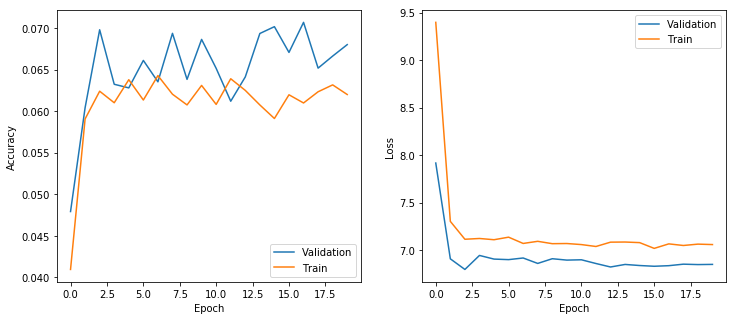

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# First, lets plot accuracy
axes[0].plot(range(len(overall_val['accuracy'])), overall_val['accuracy'], label='Validation')
axes[0].plot(range(len(overall_train['accuracy'])), overall_train['accuracy'], label='Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# then, loss
axes[1].plot(range(len(overall_val['loss'])), overall_val['loss'], label='Validation')
axes[1].plot(range(len(overall_train['loss'])), overall_train['loss'], label='Train')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()